<a href="https://colab.research.google.com/github/XiangLi368/SkinAndEyeAIModel/blob/main/Copy_of_Skin_Lesion_RightDS_SamplesizeTesting_SixClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# **Import**

In [ ]:
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import re

from numpy.random import seed
seed(101)
import os, cv2
import pandas as pd
import numpy as np
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn import metrics
from itertools import chain

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# **Check GPU**

In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  8 14:10:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |    602MiB / 40536MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Load DATA**

## **Load img**

### **ISIC2019 Train Data**

In [ ]:
#If you are using an already unzip file, you do not need to run this line
dirs = 'Dataset'
if not os.path.exists(dirs):
  os.makedirs(dirs)
!unzip '/content/drive/MyDrive/Work_Metasense/Code&Result/Dataset/ISIC2019_clean_8class_crop2square.zip' -d 'Dataset/ISIC_2019_Training_Input/'

18553


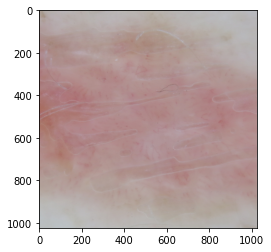

In [ ]:
# Read file path (On Cloab)
image_file = 'Dataset/ISIC_2019_Training_Input'
# Read list of images, display images
images_list = glob("Dataset/ISIC_2019_Training_Input/*.png")
print(len(images_list))
image0 = cv2.imread(images_list[0])
plt.imshow(image0[:,:,::-1])

## **Load CSV and Clean Dataset**

### **ISIC2019**

In [ ]:
#ISIC2019
df_2019 = pd.read_csv ('/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC_2019_Training_GroundTruth.csv')
print(df_2019)
df_Metadata = pd.read_csv("/content/drive/MyDrive/5703File/DataSet/dataverse_files/ISIC_2019_Training_Metadata.csv")
print(df_Metadata)
df_2019['lesion_id'] = df_Metadata['lesion_id']
# create a new colum all value is '0'
df_2019['dx'] = '0'

#Assign values to newly added columns according to GroundTruth
df_2019.loc[df_2019['MEL']== 1 ,'dx'] = 'mel'
df_2019.loc[df_2019['NV']== 1 ,'dx'] = 'nv'
df_2019.loc[df_2019['BCC']== 1 ,'dx'] = 'bcc'
df_2019.loc[df_2019['AK']== 1 ,'dx'] = 'akiec'
df_2019.loc[df_2019['BKL']== 1 ,'dx'] = 'bkl'
df_2019.loc[df_2019['DF']== 1 ,'dx'] = 'df'
df_2019.loc[df_2019['VASC']== 1 ,'dx'] = 'vasc'
df_2019.loc[df_2019['SCC']== 1 ,'dx'] = 'scc'
df_2019.loc[df_2019['UNK']== 1 ,'dx'] = 'unk'

#This is the part of the ISIC2019 dataset that has not been subdivided into other datasets
df_2019_Blank = pd.concat([df_2019[:481],df_2019[678:1229],df_2019[2364:2780]],ignore_index=True)

#Removal of nV class
df_2019_Blank = df_2019_Blank.drop(df_2019_Blank[(df_2019_Blank['dx'] =='nv')].index)

##HAM10000
df_2019[2903:12918]

#BC2000
df_3 = df_2019[12918:]

df_3 = df_3.drop(df_3[(df_3['dx'] =='nv')].index)

#Combining the three cleaned out parts
df_2019_fliter = pd.concat([df_2019_Blank,df_2019[2903:12918],df_3],ignore_index=True)

df_2019_clear = df_2019_fliter

# df_2019_clear = df_2019_clear.drop(df_2019_clear[(df_2019_clear['dx'] =='vasc') | (df_2019_clear['dx'] == 'df')| (df_2019_clear['dx'] == 'akiec')| (df_2019_clear['dx'] == 'scc')].index)

print(df_2019_clear['dx'].value_counts())

              image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 10 columns]
              image  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000        55.0      anterior torso          NaN  female
1      ISIC_0000001        30.0    

# **Create folders for training, validation and test sets**

In [ ]:
def CreateBaseDir():
    # Create a new directory
    base_dir = 'base_dir'
    os.mkdir(base_dir)

    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)

    #test_dir
    test_dir = os.path.join(base_dir, 'test_dir')
    os.mkdir(test_dir)

    # [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    nv = os.path.join(train_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(train_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(train_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(train_dir, 'bcc')
    os.mkdir(bcc)
    scc = os.path.join(train_dir, 'scc')
    os.mkdir(scc)
    others = os.path.join(train_dir, 'others')
    os.mkdir(others)

    # create new folders inside val_dir
    nv = os.path.join(val_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(val_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(val_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(val_dir, 'bcc')
    os.mkdir(bcc)
    scc = os.path.join(val_dir, 'scc')
    os.mkdir(scc)
    others = os.path.join(val_dir, 'others')
    os.mkdir(others)

    # create new folders inside test_dir
    nv = os.path.join(test_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(test_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(test_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(test_dir, 'bcc')
    os.mkdir(bcc)
    scc = os.path.join(test_dir, 'scc')
    os.mkdir(scc)
    others = os.path.join(test_dir, 'others')
    os.mkdir(others)

    return train_dir, val_dir, test_dir

In [ ]:
def DeleteBaseDir():
    shutil.rmtree("/content/base_dir")

# **Splitting the training set, validation set and test set**
This step will divide HAM10000 and BC20000 into a training set validation set and a test set respectively, and then merge them

In [ ]:
def GetHamBcn():
    df_data = df_2019_clear
    #Replace image tag with image_id
    df_data=df_data.rename(columns={'image':'image_id'})
    df = df_data

    df_bc = df[9762:]
    df_Ham = df[:9762]

    # print(df_Ham['dx'].value_counts())
    # print(df_bc['dx'].value_counts())
    # print(df['dx'].value_counts())

    return df, df_bc,df_Ham

In [ ]:
# df, df_bc,df_Ham = GetHamBcn()

In [ ]:
# print(int(6705*0.2))
# print(int(1283*0.2))
# print(int(1064*0.2))
# print(int(494*0.2))
# print(int(196*0.2))
# print(int(134*0.2))
# print(int(128*0.2))
# print(int(106*0.2))
# print(int(2988*0.2))
# print(int(2829*0.2))
# print(int(1203*0.2))
# print(int(739*0.2))
# print(int(432*0.2))
# print(int(348*0.2))
# print(int(133*0.2))
# print(int(119*0.2))

In [ ]:
#The method is to extract the corresponding quantity as soon as possible, here except for NV which is set to extract the total amount
def downsampleHAMtest(df):
    df = pd.concat([
        df.query("dx=='nv'").sample(1000,random_state=42),
        df.query("dx=='mel'").sample(256,random_state=42),
        df.query("dx=='bkl'").sample(212,random_state=42),
        df.query("dx=='bcc'").sample(98,random_state=42),
        df.query("dx=='akiec'").sample(25,random_state=42),
        df.query("dx=='df'").sample(21,random_state=42),
        df.query("dx=='vasc'").sample(26,random_state=42),
        df.query("dx=='scc'").sample(39,random_state=42),
    ])
    df['dx'].replace('akiec','others', inplace=True)
    df['dx'].replace('df','others', inplace=True)
    df['dx'].replace('vasc','others', inplace=True)
    return df
#The method is to extract the corresponding quantity as soon as possible, here except for NV which is set to extract the total amount
def downsampleBCNtest(df):
    df = pd.concat([
        df.query("dx=='mel'").sample(597,random_state=42),
        df.query("dx=='bkl'").sample(240,random_state=42),
        df.query("dx=='bcc'").sample(565,random_state=42),
        df.query("dx=='akiec'").sample(147,random_state=42),
        df.query("dx=='df'").sample(26,random_state=42),
        df.query("dx=='vasc'").sample(23,random_state=42),
        df.query("dx=='scc'").sample(86,random_state=42),
    ])
    df['dx'].replace('akiec','others', inplace=True)
    df['dx'].replace('df','others', inplace=True)
    df['dx'].replace('vasc','others', inplace=True)
    return df

In [ ]:
#The method is to extract the corresponding quantity as soon as possible, here except for NV which is set to extract the total amount
def downsampleHAM(df, SampleSize):
  HAM_nv_size = 6357-1000; HAM_mel_size = 1283-256; HAM_bkl_size=1064-212; HAM_bcc_size=494-98; HAM_scc_size=196-39; HAM_vasc_size=108; HAM_akiec_size=103; HAM_df_size=85;

  nv_size = SampleSize if HAM_nv_size >= SampleSize else HAM_nv_size
  mel_size = int(SampleSize/2) if HAM_mel_size >= int(SampleSize/2) else HAM_mel_size
  bkl_size = int(SampleSize/2) if HAM_bkl_size >= int(SampleSize/2) else HAM_bkl_size
  bcc_size = int(SampleSize/2) if HAM_bcc_size >= int(SampleSize/2) else HAM_bcc_size
  vasc_size = int(SampleSize/6) if HAM_vasc_size >= int(SampleSize/6) else HAM_vasc_size
  akiec_size = int(SampleSize/6) if HAM_akiec_size >= int(SampleSize/6) else HAM_akiec_size
  df_size = int(SampleSize/6) if HAM_df_size >= int(SampleSize/6) else HAM_df_size

  df = pd.concat([
      df.query("dx=='nv'").sample(nv_size,random_state=42),
      df.query("dx=='mel'").sample(mel_size,random_state=42),
      df.query("dx=='bkl'").sample(bkl_size,random_state=42),
      df.query("dx=='bcc'").sample(bcc_size,random_state=42),
      df.query("dx=='akiec'").sample(akiec_size,random_state=42),
      df.query("dx=='df'").sample(df_size,random_state=42),
      df.query("dx=='vasc'").sample(vasc_size,random_state=42),
      df.query("dx=='scc'")
  ])

  df['dx'].replace('akiec','others', inplace=True)
  df['dx'].replace('df','others', inplace=True)
  df['dx'].replace('vasc','others', inplace=True)

  return df
# df_Ham_down = downsampleHAM(df_Ham, 780)
# print(df_Ham_down['dx'].value_counts())

In [ ]:
#The method is to extract the corresponding quantity as soon as possible, here except for NV which is set to extract the total amount
def downsampleBCN(df, SampleSize):
  BCN_mel_size=2988-597; BCN_bcc_size=2829-565; BCN_bkl_size=1203-240; BCN_akiec_size=739-147; BCN_df_size=107; BCN_vasc_size=96

  if (BCN_mel_size <= int(SampleSize/2)):
    mel_size = BCN_mel_size
  elif ((int(SampleSize/2)+(1283-256)) < SampleSize):
    mel_size = SampleSize - (1283-256)
  elif (int(SampleSize/2) <= BCN_mel_size):
    mel_size = int(SampleSize/2)

  if (BCN_bkl_size <= int(SampleSize/2)):
    bkl_size = BCN_bkl_size
  elif ((int(SampleSize/2)+(1064-212)) < SampleSize):
    bkl_size = SampleSize - (1064-212)
  elif (int(SampleSize/2) <= BCN_bkl_size):
    bkl_size = int(SampleSize/2)

  if (BCN_bcc_size <= int(SampleSize/2)):
    bcc_size = BCN_bcc_size
  elif ((int(SampleSize/2) + (494-98)) < SampleSize):
    bcc_size = SampleSize - (494-98)
  elif (int(SampleSize/2) <= BCN_bcc_size):
    bcc_size = int(SampleSize/2)

  vasc_size = int(SampleSize/6) if BCN_vasc_size >= int(SampleSize/6) else BCN_vasc_size
  df_size = int(SampleSize/6) if BCN_df_size >= int(SampleSize/6) else BCN_df_size

  if(BCN_akiec_size >= int(SampleSize/6) and SampleSize < BCN_akiec_size):
    akiec_size = int(SampleSize/6)
  elif(SampleSize < (BCN_akiec_size+499) and SampleSize >= BCN_akiec_size):
    akiec_size = SampleSize - 499
  elif(SampleSize >= (BCN_akiec_size+499)):
    akiec_size = BCN_akiec_size

  df = pd.concat([
      df.query("dx=='mel'").sample(mel_size,random_state=42),
      df.query("dx=='bkl'").sample(bkl_size,random_state=42),
      df.query("dx=='bcc'").sample(bcc_size,random_state=42),
      df.query("dx=='akiec'").sample(akiec_size,random_state=42),
      df.query("dx=='df'").sample(df_size,random_state=42),
      df.query("dx=='vasc'").sample(vasc_size,random_state=42),
      df.query("dx=='scc'")
  ])

  df['dx'].replace('akiec','others', inplace=True)
  df['dx'].replace('df','others', inplace=True)
  df['dx'].replace('vasc','others', inplace=True)
  return df

In [ ]:
def test_trainVal_split(df, df_test):

    code_list=df_test['image_id'].tolist()
    df=df[~df['image_id'].isin(code_list)]

    return df


In [ ]:
def SplitDs(df):
    y = df['dx']

    df_train, df_val = train_test_split(df, test_size=0.1, random_state=100, stratify=y)

    return df_train, df_val

In [ ]:
def combine2Df(df1, df2):
    df = pd.concat([df1,df2],ignore_index=True)
    return df

# **Transfer the Images into the Folders**

In [ ]:
def transFile(df_data, df_train, df_val, df_test, train_dir, val_dir, test_dir):
    # Set the image_id as the index in df_data
    df_data.set_index('image_id', inplace=True)

    df_data['dx'].replace('akiec','others', inplace=True)
    df_data['dx'].replace('df','others', inplace=True)
    df_data['dx'].replace('vasc','others', inplace=True)
    # print(df_data['dx'].value_counts())
    # Get a list of images in the folder
    folder_1 = os.listdir(image_file)

    # Get a list of train val and test images
    train_images = list(df_train.image_id)
    train_labels = list(df_train.dx)
    val_images = list(df_val.image_id)
    val_labels = list(df_val.dx)
    test_images = list(df_test.image_id)
    test_labels = list(df_test.dx)
    # Transfer the train images

    for image in tqdm(train_images):

        fname = image + '.png'
        label = df_data.loc[image,'dx']

        if fname in folder_1:
            # source path to image
            src = os.path.join(image_file, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

    # Transfer the val images

    for image in tqdm(val_images):

        fname = image + '.png'
        label = df_data.loc[image,'dx']

        if fname in folder_1:
            # source path to image
            src = os.path.join(image_file, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

    # Transfer the test images

    for image in tqdm(test_images):

        fname = image + '.png'
        label = df_data.loc[image,'dx']

        if fname in folder_1:
            # source path to image
            src = os.path.join(image_file, fname)
            # destination path to image
            dst = os.path.join(test_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


# **Model Building**

## **Method for Create a Confusion Matrix**

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Xception**

In [ ]:
# image_height: The imput height of the image
# image_width: The imput width of the image
# es_patience: Parameters for EarlyStoppingpatience
# lr_patience: Parameters for ReduceLROnPlateau
# min_learningrate: Parameters for ReduceLROnPlateau,means the min learning rate
# epochs_num: epoch number
# batch_size: batch size
# in_learning_rate: Initial learning rate
def Xception_structure(image_height,image_width,es_patience,lr_patience,min_learningrate,epochs_num,batch_size,in_learning_rate,train_lenth,df_val,df_test):
    train_path = 'base_dir/train_dir'
    valid_path = 'base_dir/val_dir'
    test_path = 'base_dir/test_dir'

    # num_train_samples = len(df_train)
    num_train_samples = train_lenth
    num_val_samples = len(df_val)
    num_test_samples = len(df_test)
    train_batch_size = batch_size
    val_batch_size = batch_size
    test_batch_size = batch_size

    train_steps = np.ceil(num_train_samples / train_batch_size)
    val_steps = np.ceil(num_val_samples / val_batch_size)
    test_steps = np.ceil(num_test_samples / test_batch_size)
    ####################################################################
    datagen = ImageDataGenerator(
        preprocessing_function= \
        tf.keras.applications.xception.preprocess_input)

    train_batches = datagen.flow_from_directory(train_path,
                                                target_size=(image_height,image_width),
                                                batch_size=train_batch_size)

    valid_batches = datagen.flow_from_directory(valid_path,
                                                target_size=(image_height,image_width),
                                                batch_size=val_batch_size)

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_batches = datagen.flow_from_directory(test_path,
                                                target_size=(image_height,image_width),
                                                batch_size=1,
                                                shuffle=False)
    #####################################################################
    # create a copy of a Xception model
    model_X = tf.keras.applications.xception.Xception()
    # model_X.summary()
    # CREATE THE MODEL ARCHITECTURE

    # This will include all layers up to and including global_average_pooling2d_1
    x = model_X.layers[-2].output

    # Create a new dense layer for predictions because we are 4 class
    x = Dropout(0.30)(x)
    predictions = Dense(6, activation='softmax')(x)

    model_X = Model(inputs=model_X.input, outputs=predictions)

    # model_X.summary()
    #######################################################################
    # Get the labels that are associated with each index
    print(valid_batches.class_indices)
    # {'akiec': 0, 'bcc': 1, 'bkl': 2, 'mel': 3, 'nv': 4, 'scc': 5}

    # Add weights to try to make the model more sensitive to melanoma

    class_weights={
        0: 1.0, #
        1: 1.0, #
        2: 1.0, #
        3: 1.0, #
        4: 1.0, #
        5: 1.0, #
        # 6: 1.0, #
    }
    #######################################################################
    model_X.compile(Adam(learning_rate=in_learning_rate), loss='categorical_crossentropy',
                    metrics=[categorical_accuracy])

    filepath = "Model/Skin Lesion 299 Random resize 92%.h5" # The pass to save model

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                                save_best_only=True, mode='auto')

    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=es_patience,
                                                    verbose=1, mode='auto',
                                                    restore_best_weights=False)

    reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.4, patience=lr_patience,
                                        verbose=1, mode='auto', min_lr=min_learningrate)


    callbacks_list = [es_callback,checkpoint, reduce_lr]

    history = model_X.fit(train_batches, steps_per_epoch=train_steps,
                                    class_weight=class_weights,
                        validation_data=valid_batches,
                        validation_steps=val_steps,
                        epochs=epochs_num, verbose=1,
                        callbacks=callbacks_list)
    ######################################################################### Evaluation
    #Draw loss figure
    # get the metric names so we can use evaulate_generator
    model_X.metrics_names

    # Here the the last epoch will be used.

    test_loss1, test_cat_acc1 = \
    model_X.evaluate(test_batches,
                            steps=len(df_test))

    print('test_loss_last:', test_loss1)
    print('test_cat_acc_last:', test_cat_acc1)

    # Here the best epoch will be used.

    model_X.load_weights('Model/Skin Lesion 299 Random resize 92%.h5')

    test_loss, test_cat_acc = \
    model_X.evaluate(test_batches,
                            steps=len(df_test))

    print('test_loss:', test_loss)
    print('test_cat_acc:', test_cat_acc)


    #display the loss and accuracy curves

    import matplotlib.pyplot as plt

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training cat acc')
    plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
    plt.title('Training and validation cat accuracy')
    plt.legend()
    plt.figure()


    plt.show()
    ######################################################################### Evaluation
    #Draw Confusion matrix

    # Get the labels of the test images.

    test_labels = test_batches.classes
    # We need these to plot the confusion matrix.
    test_labels

    # Print the label associated with each class
    test_batches.class_indices

    # make a prediction
    predictions = model_X.predict(test_batches, steps=len(df_test), verbose=1)
    # len test by gordon

    test_labels.shape
    # argmax returns the index of the max value in a row
    cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
    test_batches.class_indices

    # Define the labels of the class indices. These need to match the
    # order shown above.
    cm_plot_labels = ['bcc','bkl','mel','nv','others','scc']

    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    ######################################################################### Evaluation
    # Get report
    # Get the index of the class with the highest probability score
    y_pred = np.argmax(predictions, axis=1)

    # Get the labels of the test images.
    y_true = test_batches.classes

    # Generate a classification report
    report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

    print(report)
    ######################################################################### Evaluation
    #Get Specificity
    print('Specificity of each class:')
    spe = []
    classnum = len(cm_plot_labels)
    for i in range(classnum):
        number = np.sum(cm[:,:])
        tp = cm[i][i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = number - tp - fn - fp
        spe1 = tn / (tn + fp)
        spe.append(spe1)
        print(cm_plot_labels[i],':','%.3f'%spe1)
    ######################################################################### Evaluation
    #Draw ROC&AUC

    def f(i):
        l = [0, 0, 0, 0, 0, 0]
        l[i] = 1
        return l
    #Calculation
    y_pre = list(map(f,test_batches.classes))
    y = sum(y_pre,[])
    scores = list(chain.from_iterable(predictions))

    yscore = predictions.tolist()


    # Calculate the ROC for each category
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(cm_plot_labels)):
        fpr[i], tpr[i], thresholds = metrics.roc_curve([m[i] for m in y_pre], [n[i] for n in yscore], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(cm_plot_labels))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(cm_plot_labels)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(cm_plot_labels)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Plot all ROC curves
    lw=2
    plt.figure(figsize=(10,10))


    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.3f})'
                    ''.format(roc_auc["macro"]),
            color='r',  linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(cm_plot_labels)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,linestyle=':',
                label='ROC curve of class {0} (area = {1:0.3f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Xception')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
    plt.show()

# Train

In [ ]:
df, df_bc,df_Ham = GetHamBcn()
# df_Ham_test = downsampleHAMtest(df_Ham)
# df_bc_test = downsampleBCNtest(df_bc)

In [ ]:
# print(df_Ham_test['dx'].value_counts())
# print(df_bc_test['dx'].value_counts())
# df_Ham_test.to_csv("/content/drive/MyDrive/Work_Metasense/Code&Result/model/df_Ham_test_sixClass.csv")
# df_bc_test.to_csv("/content/drive/MyDrive/Work_Metasense/Code&Result/model/df_bc_test_sixClass.csv")

In [ ]:
# load the test df
df_Ham_test = pd.read_csv("/content/drive/MyDrive/Work_Metasense/Code&Result/model/df_Ham_test_sixClass.csv")
df_bc_test = pd.read_csv("/content/drive/MyDrive/Work_Metasense/Code&Result/model/df_bc_test_sixClass.csv")

In [ ]:
def train_model(Samplesize,image_height,image_width,es_patience,lr_patience,min_learningrate,batch_size,in_learning_rate,n):

    #create base dir
    train_dir, val_dir, test_dir = CreateBaseDir()

    #Seperate df and train/val/test
    df, df_bc,df_Ham = GetHamBcn()

    #split test ds
    df_Ham = test_trainVal_split(df_Ham, df_Ham_test)
    df_bc = test_trainVal_split(df_bc, df_bc_test)

    df_Ham_down = downsampleHAM(df_Ham, Samplesize)
    df_bc_down = downsampleBCN(df_bc, Samplesize)

    df_train_Ham, df_val_Ham = SplitDs(df_Ham_down)
    df_train_bc, df_val_bc = SplitDs(df_bc_down)

    #Combine two data set
    df_train = combine2Df(df_train_Ham, df_train_bc)
    df_val = combine2Df(df_val_Ham, df_val_bc)
    df_test = combine2Df(df_Ham_test, df_bc_test)

    print(df_train['dx'].value_counts())
    print(df_val['dx'].value_counts())
    print(df_test['dx'].value_counts())

    # Transfer file
    transFile(df, df_train, df_val, df_test, train_dir, val_dir, test_dir)
    # Training length
    train_lenth = len(os.listdir('/content/base_dir/train_dir/nv'))+len(os.listdir('/content/base_dir/train_dir/mel'))+len(os.listdir('/content/base_dir/train_dir/bkl'))+len(os.listdir('/content/base_dir/train_dir/bcc'))+len(os.listdir('/content/base_dir/train_dir/others'))+len(os.listdir('/content/base_dir/train_dir/scc'))

    # Training
    for i in range(1,n+1):
        print("This is samplesize " + str(Samplesize) + " " + str(i))
        Xception_structure(image_height=image_height,image_width=image_width,es_patience=es_patience,lr_patience=lr_patience,min_learningrate=min_learningrate,epochs_num=60,batch_size=batch_size,in_learning_rate=in_learning_rate,train_lenth=train_lenth,df_val=df_val,df_test=df_test)

    #delete the base dir and next we can go another sample size
    DeleteBaseDir()

In [ ]:
# DeleteBaseDir()

#Test 450 Res

nv        2160
mel       2160
bcc       2159
bkl       1634
others     982
scc        452
Name: dx, dtype: int64
bcc       241
nv        240
mel       240
bkl       181
others    109
scc        51
Name: dx, dtype: int64
nv        1000
mel        853
bcc        663
bkl        452
others     268
scc        125
Name: dx, dtype: int64


100%|██████████| 3361/3361 [00:37<00:00, 88.51it/s] 


This is samplesize 2400 1
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 1.0209 - categorical_accuracy: 0.6231
Epoch 1: val_categorical_accuracy improved from -inf to 0.56309, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 406s 3s/step - loss: 1.0209 - categorical_accuracy: 0.6231 - val_loss: 1.2951 - val_categorical_accuracy: 0.5631 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.7406 - categorical_accuracy: 0.7202
Epoch 2: val_categorical_accuracy did not improve from 0.56309
150/150 [==============================] - 416s 3s/step - loss: 0.7406 - categorical_accuracy: 0.7202 - val_loss: 2.0181 - val_categorical_accuracy: 0.4944 - lr: 0.0010
Epoch 3/60
150/150 [========================

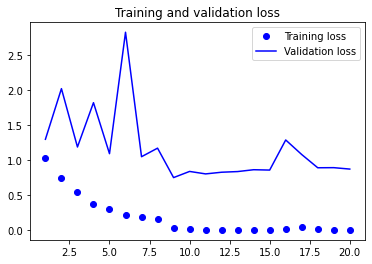

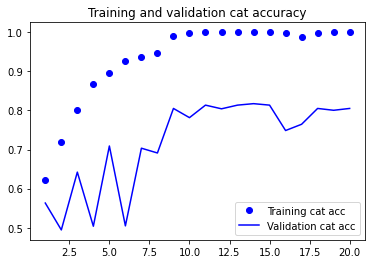

<Figure size 432x288 with 0 Axes>

3361/3361 [==============================] - 57s 17ms/step
Confusion matrix, without normalization
[[591  14  25   2  24   7]
 [ 28 336  34  28  25   1]
 [ 33  43 695  52  27   3]
 [  7  22  31 935   5   0]
 [ 43  23  14   5 175   8]
 [ 27  10   8   1  12  67]]
              precision    recall  f1-score   support

         bcc       0.81      0.89      0.85       663
         bkl       0.75      0.74      0.75       452
         mel       0.86      0.81      0.84       853
          nv       0.91      0.94      0.92      1000
      others       0.65      0.65      0.65       268
         scc       0.78      0.54      0.64       125

    accuracy                           0.83      3361
   macro avg       0.79      0.76      0.77      3361
weighted avg       0.83      0.83      0.83      3361

Specificity of each class:
bcc : 0.949
bkl : 0.961
mel : 0.955
nv : 0.963
others : 0.970
scc : 0.994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


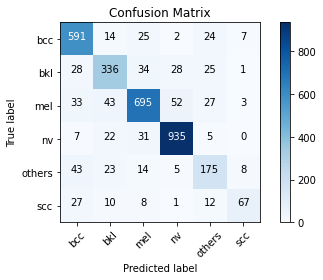

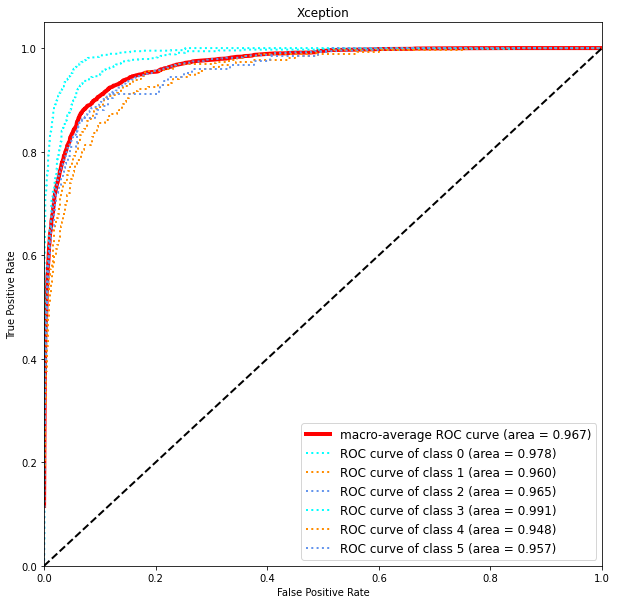

This is samplesize 2400 2
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.6248
Epoch 1: val_categorical_accuracy improved from -inf to 0.54614, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 354s 2s/step - loss: 1.0031 - categorical_accuracy: 0.6248 - val_loss: 1.3938 - val_categorical_accuracy: 0.5461 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.6969 - categorical_accuracy: 0.7440
Epoch 2: val_categorical_accuracy did not improve from 0.54614
150/150 [==============================] - 339s 2s/step - loss: 0.6969 - categorical_accuracy: 0.7440 - val_loss: 2.0424 - val_categorical_accuracy: 0.4605 - lr: 0.0010
Epoch 3/60
150/150 [========================

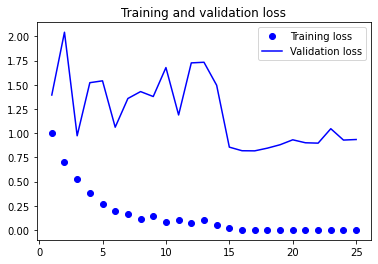

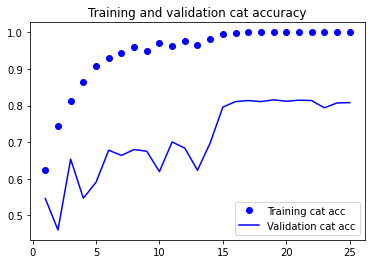

<Figure size 432x288 with 0 Axes>

3361/3361 [==============================] - 53s 16ms/step
Confusion matrix, without normalization
[[588  13  20   2  24  16]
 [ 31 342  32  26  18   3]
 [ 38  57 672  52  22  12]
 [  7  13  31 943   5   1]
 [ 39  20  13   7 179  10]
 [ 24   4   8   3  10  76]]
              precision    recall  f1-score   support

         bcc       0.81      0.89      0.85       663
         bkl       0.76      0.76      0.76       452
         mel       0.87      0.79      0.83       853
          nv       0.91      0.94      0.93      1000
      others       0.69      0.67      0.68       268
         scc       0.64      0.61      0.63       125

    accuracy                           0.83      3361
   macro avg       0.78      0.78      0.78      3361
weighted avg       0.83      0.83      0.83      3361

Specificity of each class:
bcc : 0.948
bkl : 0.963
mel : 0.959
nv : 0.962
others : 0.974
scc : 0.987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


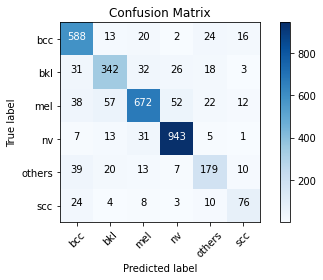

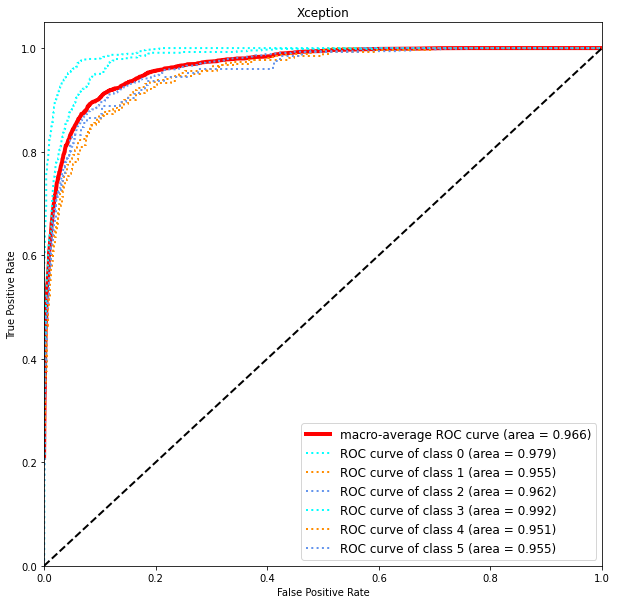

This is samplesize 2400 3
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 1.0109 - categorical_accuracy: 0.6201
Epoch 1: val_categorical_accuracy improved from -inf to 0.48305, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 361s 2s/step - loss: 1.0109 - categorical_accuracy: 0.6201 - val_loss: 2.8257 - val_categorical_accuracy: 0.4831 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.7179 - categorical_accuracy: 0.7350
Epoch 2: val_categorical_accuracy improved from 0.48305 to 0.68173, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 359s 2s/step - loss: 0.7179 - categorical_accuracy: 0.7350 - val_loss: 0.9977 - val_categorical_accuracy: 

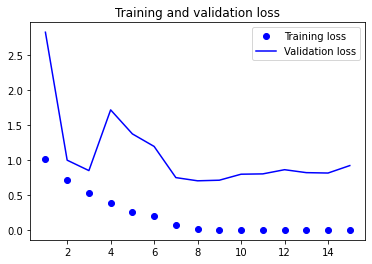

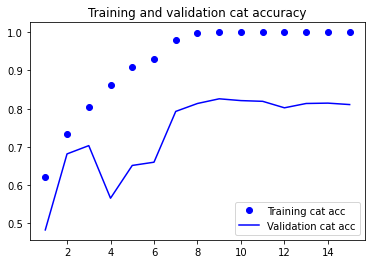

<Figure size 432x288 with 0 Axes>

3361/3361 [==============================] - 53s 16ms/step
Confusion matrix, without normalization
[[586   9  22   1  31  14]
 [ 25 346  30  22  22   7]
 [ 29  53 698  44  25   4]
 [ 13  22  44 914   6   1]
 [ 40  19  10   4 180  15]
 [ 24  10   7   3   8  73]]
              precision    recall  f1-score   support

         bcc       0.82      0.88      0.85       663
         bkl       0.75      0.77      0.76       452
         mel       0.86      0.82      0.84       853
          nv       0.93      0.91      0.92      1000
      others       0.66      0.67      0.67       268
         scc       0.64      0.58      0.61       125

    accuracy                           0.83      3361
   macro avg       0.78      0.77      0.77      3361
weighted avg       0.83      0.83      0.83      3361

Specificity of each class:
bcc : 0.951
bkl : 0.961
mel : 0.955
nv : 0.969
others : 0.970
scc : 0.987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


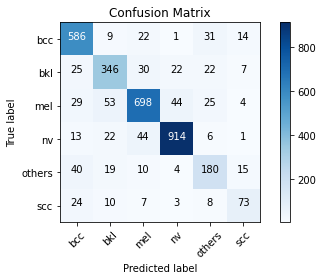

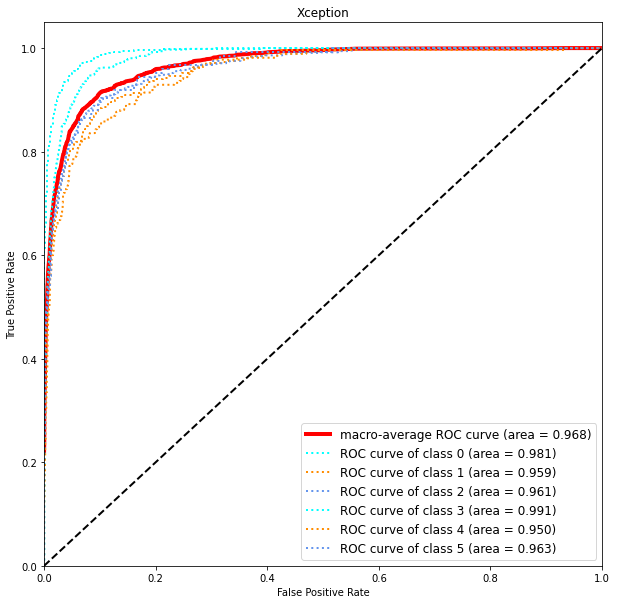

This is samplesize 2400 4
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 1.0199 - categorical_accuracy: 0.6181
Epoch 1: val_categorical_accuracy improved from -inf to 0.49906, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 401s 3s/step - loss: 1.0199 - categorical_accuracy: 0.6181 - val_loss: 2.7257 - val_categorical_accuracy: 0.4991 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.7351 - categorical_accuracy: 0.7323
Epoch 2: val_categorical_accuracy did not improve from 0.49906
150/150 [==============================] - 401s 3s/step - loss: 0.7351 - categorical_accuracy: 0.7323 - val_loss: 2.9762 - val_categorical_accuracy: 0.4802 - lr: 0.0010
Epoch 3/60
150/150 [========================

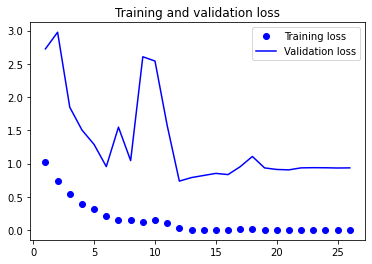

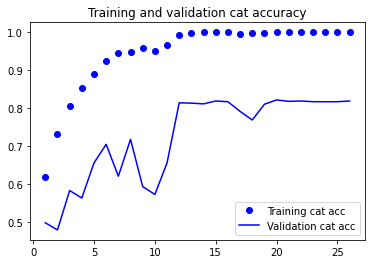

<Figure size 432x288 with 0 Axes>

3361/3361 [==============================] - 57s 17ms/step
Confusion matrix, without normalization
[[593  17  14   5  28   6]
 [ 29 347  37  15  19   5]
 [ 36  60 683  43  27   4]
 [  7  21  48 917   6   1]
 [ 43  23  10   5 182   5]
 [ 27  13   5   0  13  67]]
              precision    recall  f1-score   support

         bcc       0.81      0.89      0.85       663
         bkl       0.72      0.77      0.74       452
         mel       0.86      0.80      0.83       853
          nv       0.93      0.92      0.92      1000
      others       0.66      0.68      0.67       268
         scc       0.76      0.54      0.63       125

    accuracy                           0.83      3361
   macro avg       0.79      0.77      0.77      3361
weighted avg       0.83      0.83      0.83      3361

Specificity of each class:
bcc : 0.947
bkl : 0.954
mel : 0.955
nv : 0.971
others : 0.970
scc : 0.994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


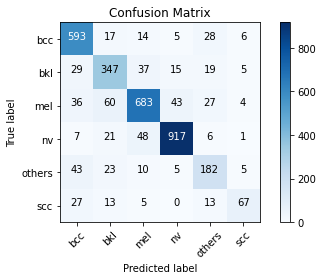

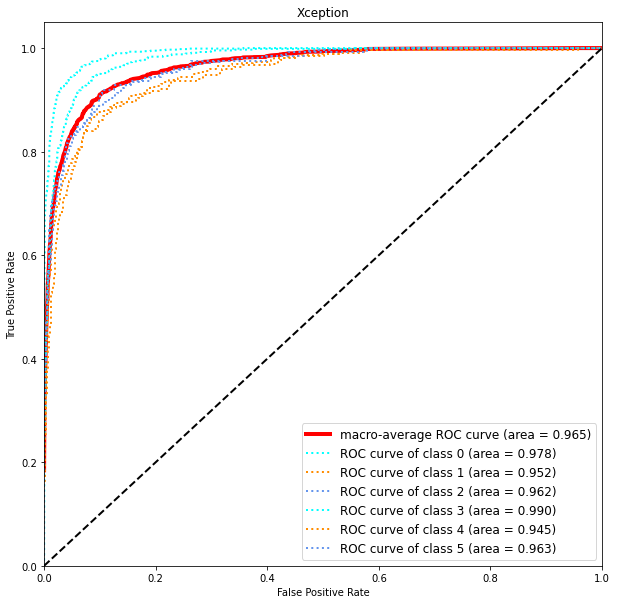

This is samplesize 2400 5
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 1.0149 - categorical_accuracy: 0.6275
Epoch 1: val_categorical_accuracy improved from -inf to 0.63936, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 420s 3s/step - loss: 1.0149 - categorical_accuracy: 0.6275 - val_loss: 1.5064 - val_categorical_accuracy: 0.6394 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.7003 - categorical_accuracy: 0.7382
Epoch 2: val_categorical_accuracy improved from 0.63936 to 0.71375, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 408s 3s/step - loss: 0.7003 - categorical_accuracy: 0.7382 - val_loss: 0.8335 - val_categorical_accuracy: 

KeyboardInterrupt: ignored

In [ ]:
train_model(2400, 450, 450, 6, 3, 0.00000001, 64, 0.001, 5)

nv        2160
mel       2160
bcc       2159
bkl       1634
others     982
scc        452
Name: dx, dtype: int64
bcc       241
nv        240
mel       240
bkl       181
others    109
scc        51
Name: dx, dtype: int64
nv        1000
mel        853
bcc        663
bkl        452
others     268
scc        125
Name: dx, dtype: int64


100%|██████████| 3361/3361 [00:35<00:00, 94.71it/s]


This is samplesize 2400 1
Found 9547 images belonging to 6 classes.
Found 1062 images belonging to 6 classes.
Found 3361 images belonging to 6 classes.
{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3, 'others': 4, 'scc': 5}
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 0.9986 - categorical_accuracy: 0.6281
Epoch 1: val_categorical_accuracy improved from -inf to 0.40960, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 405s 3s/step - loss: 0.9986 - categorical_accuracy: 0.6281 - val_loss: 3.6606 - val_categorical_accuracy: 0.4096 - lr: 0.0010
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.7088 - categorical_accuracy: 0.7378
Epoch 2: val_categorical_accuracy improved from 0.40960 to 0.61299, saving model to Model/Skin Lesion 299 Random resize 92%.h5
150/150 [==============================] - 427s 3s/step - loss: 0.7088 - categorical_accuracy: 0.7378 - val_loss: 1.3434 - val_categorical_accuracy: 

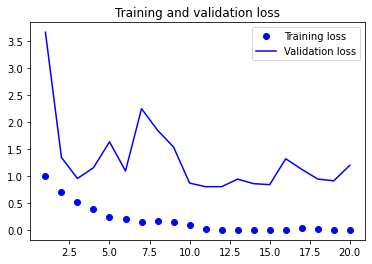

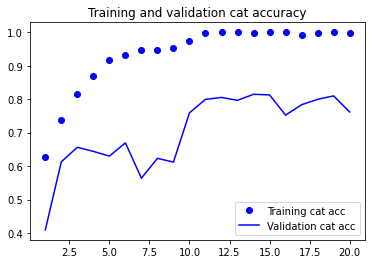

<Figure size 432x288 with 0 Axes>

3361/3361 [==============================] - 53s 16ms/step
Confusion matrix, without normalization
[[591  17  17   0  23  15]
 [ 28 336  39  22  20   7]
 [ 34  56 693  41  26   3]
 [ 10  23  41 917   6   3]
 [ 31  26  15   3 183  10]
 [ 21  10   7   2   9  76]]
              precision    recall  f1-score   support

         bcc       0.83      0.89      0.86       663
         bkl       0.72      0.74      0.73       452
         mel       0.85      0.81      0.83       853
          nv       0.93      0.92      0.92      1000
      others       0.69      0.68      0.68       268
         scc       0.67      0.61      0.64       125

    accuracy                           0.83      3361
   macro avg       0.78      0.78      0.78      3361
weighted avg       0.83      0.83      0.83      3361

Specificity of each class:
bcc : 0.954
bkl : 0.955
mel : 0.953
nv : 0.971
others : 0.973
scc : 0.988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


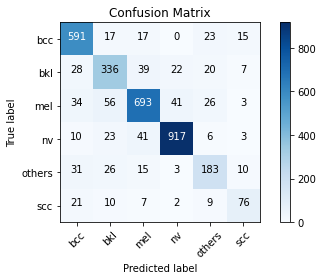

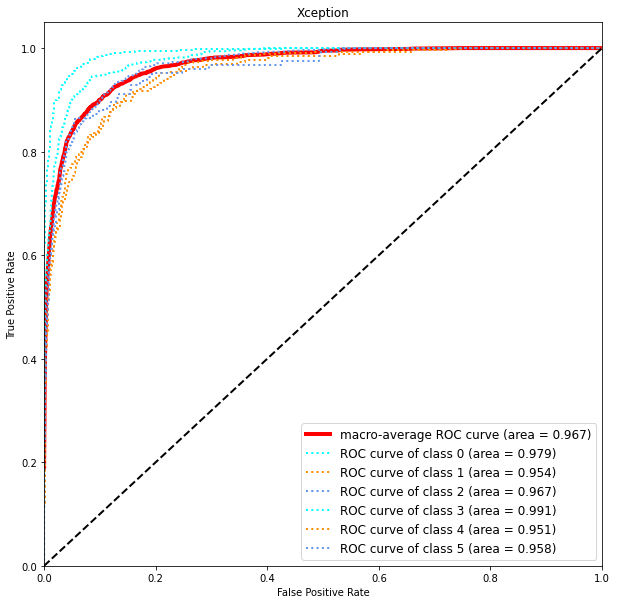

In [ ]:
train_model(2400, 450, 450, 6, 3, 0.00000001, 64, 0.001, 1)